# Code Similarity: A Machine Learning Project

## Project Inicialization

In [15]:
import json, time, os, io
from contextlib import redirect_stdout, redirect_stderr
from listener import FeatureExtractorListener, walk_tree
from parser.parser import parse_project
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

DATA_FOLDER = f'{os.getcwd()}/data/'

os.makedirs(DATA_FOLDER, exist_ok=True)

## Extrayendo Los AST

In [16]:
project_features = []

for f in os.scandir(PROJECTS_FOLDER):
    if f.is_dir():
        print(PROJECTS_FOLDER + f.name)
        try:
            # Create an in-memory buffer
            buffer = io.StringIO()
            with redirect_stdout(buffer), redirect_stderr(buffer):
                ast = parse_project(PROJECTS_FOLDER + f.name)
        except:
            print("Error Detected")
            continue
        
        extractor = FeatureExtractorListener()
        walk_tree(extractor, ast)
        features = extractor.get_features()
        features['project_name'] = f.name
        project_features.append(features)
        
# Generar un nombre de archivo JSON único usando la marca de tiempo
timestamp = time.strftime("%Y%m%d-%H%M%S")
output_json_path = os.path.join(DATA_FOLDER, f"features_{timestamp}.json")

# Guardar los features en un archivo JSON
with open(output_json_path, 'w', encoding='utf-8') as json_file:
    json.dump(project_features, json_file, ensure_ascii=False, indent=4)    

c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/Domino-master
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/Domino-Project-Domino
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/Dominoes-main
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/DominoGame-main
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/MachiDomino-main
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/moogle-main
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/n-omino-main
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/Proyect-MATCOM-main
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/Proyecto-de-Pro-main
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/Proyecto-Domino--master
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/Proyecto-Programacion-Mad-Kev-main
c:\Users\Chony\Desktop\Tesis\Fraud_Detector_Plus/Projects/Second_Project_Dominoes-main


## Features Extraídos y su Importancia:

1. **`total_nodes`**
   - **Descripción**: Número total de nodos visitados en el árbol de sintaxis.
   - **Importancia**: Indica el tamaño del código fuente y la complejidad general del análisis.

2. **`node_count`**
   - **Descripción**: Diccionario que mantiene el conteo de cada tipo de nodo encontrado.
   - **Importancia**: Permite identificar qué tipos de constructos de lenguaje se utilizan más frecuentemente.

3. **`max_depth`**
   - **Descripción**: Profundidad máxima alcanzada en el árbol de sintaxis.
   - **Importancia**: Una mayor profundidad puede indicar una estructura de código más compleja y anidada.

4. **`variables`**
   - **Descripción**: Número de variables declaradas en el código.
   - **Importancia**: Indica la cantidad de almacenamiento local usado, lo cual puede reflejar la complejidad del estado manejado por el programa.

5. **`constants`**
   - **Descripción**: Número de constantes declaradas.
   - **Importancia**: Las constantes pueden indicar valores inmutables importantes y buenas prácticas de programación.

6. **`out_variables`**
   - **Descripción**: Número de variables de salida (out) declaradas.
   - **Importancia**: Las variables de salida son importantes para el flujo de datos y la gestión de resultados en métodos.

7. **`methods`**
   - **Descripción**: Número de métodos definidos.
   - **Importancia**: Ayuda a medir la modularidad y el tamaño funcional del código.

8. **`classes`**
   - **Descripción**: Número de clases definidas.
   - **Importancia**: Permite entender la estructura orientada a objetos del código.

9. **`interfaces`**
   - **Descripción**: Número de interfaces definidas.
   - **Importancia**: Las interfaces son cruciales para la abstracción y la definición de contratos en programación orientada a objetos.

10. **`abstract_classes`**
    - **Descripción**: Número de clases abstractas definidas.
    - **Importancia**: Las clases abstractas indican puntos de extensión y abstracción.

11. **`sealed_classes`**
    - **Descripción**: Número de clases selladas definidas.
    - **Importancia**: Las clases selladas indican clases que no pueden ser heredadas, lo cual puede ser útil para seguridad y optimización.

12. **`import_statements`**
    - **Descripción**: Número de declaraciones de importación (`using`).
    - **Importancia**: Refleja las dependencias y bibliotecas externas utilizadas en el código.

13. **`function_calls`**
    - **Descripción**: Número de llamadas a funciones.
    - **Importancia**: Indica el uso y la frecuencia de las funciones en el código.

14. **`try_catch_blocks`**
    - **Descripción**: Número de bloques try-catch.
    - **Importancia**: Refleja el manejo de excepciones y la robustez del código ante errores.

15. **`lists`**
    - **Descripción**: Número de listas utilizadas en el código.
    - **Importancia**: Las listas son estructuras de datos importantes y su uso puede indicar la gestión de colecciones.

16. **`dicts`**
    - **Descripción**: Número de diccionarios utilizados en el código.
    - **Importancia**: Los diccionarios son estructuras de datos importantes para el almacenamiento de pares clave-valor.

17. **`variable_names`**
    - **Descripción**: Conjunto de nombres de variables únicas.
    - **Importancia**: Ayuda a la identificación y análisis de la nomenclatura y la reutilización de nombres.

18. **`method_names`**
    - **Descripción**: Conjunto de nombres de métodos únicos.
    - **Importancia**: Útil para la identificación y análisis de la nomenclatura de métodos.

19. **`method_lengths`**
    - **Descripción**: Lista con la longitud de cada método.
    - **Importancia**: Métodos más largos pueden ser más complejos y difíciles de mantener.

20. **`class_names`**
    - **Descripción**: Conjunto de nombres de clases únicas.
    - **Importancia**: Ayuda a la identificación y análisis de la nomenclatura de clases.

21. **`interface_names`**
    - **Descripción**: Conjunto de nombres de interfaces únicas.
    - **Importancia**: Útil para la identificación y análisis de la nomenclatura de interfaces.

22. **`enum_names`**
    - **Descripción**: Conjunto de nombres de enumeraciones únicas.
    - **Importancia**: Mejora la legibilidad y la mantenibilidad del código, indicando constantes relacionadas.

23. **`delegate_names`**
    - **Descripción**: Conjunto de nombres de delegados únicos.
    - **Importancia**: Facilita la comprensión y el seguimiento de las referencias de métodos pasados como argumentos.

24. **`distinct_tokens`**
    - **Descripción**: Diccionario de tokens distintos y su conteo.
    - **Importancia**: Permite comprender la diversidad y la frecuencia de los tokens utilizados en el código.

25. **`control_structures`**
    - **Descripción**: Diccionario que cuenta las estructuras de control (`if`, `switch`, `for`, `while`, `dowhile`).
    - **Importancia**: Ayuda a entender el flujo lógico y las decisiones en el código.

26. **`access_modifiers_methods`**
    - **Descripción**: Diccionario que cuenta los modificadores de acceso en métodos (`public`, `private`, `protected`, etc.).
    - **Importancia**: Los modificadores indican la visibilidad y el control de acceso de los métodos, crucial para la encapsulación y la seguridad del código.

27. **`other_modifiers`**
    - **Descripción**: Diccionario que cuenta otros modificadores (`readonly`, `volatile`, `virtual`, `override`, etc.).
    - **Importancia**: Indican comportamientos especiales de métodos y variables, afectando la semántica y optimización del código.

28. **`library_calls`**
    - **Descripción**: Diccionario que cuenta las llamadas a ciertas bibliotecas (`Console`, `Math`).
    - **Importancia**: Refleja el uso de bibliotecas estándar y puede indicar dependencias clave en el código.

29. **`linq_queries`**
    - **Descripción**: Diccionario que cuenta las diferentes consultas LINQ utilizadas (`Select`, `Where`, `OrderBy`, etc.).
    - **Importancia**: LINQ es una característica poderosa en C# para manejar colecciones y datos, y su uso puede indicar un enfoque funcional en el código.

30. **`method_return_types`**
    - **Descripción**: Diccionario que almacena los tipos de retorno de los métodos.
    - **Importancia**: Permite comprender los tipos de datos devueltos por los métodos, lo cual es crucial para el análisis de tipos y la comprensión del flujo de datos.

31. **`method_parameters`**
    - **Descripción**: Diccionario que almacena los parámetros de los métodos.
    - **Importancia**: Proporciona información sobre la firma de los métodos, ayudando a entender cómo se intercambian los datos en el programa.

32. **`number_of_enums`**
    - **Descripción**: Número de enumeraciones (enum) definidas.
    - **Importancia**: Los enums proporcionan una manera de definir conjuntos de constantes relacionadas, mejorando la legibilidad y la mantenibilidad del código.

33. **`number_of_delegates`**
    - **Descripción**: Número de delegados definidos.
    - **Importancia**: Los delegados son tipos que representan referencias a métodos, permitiendo pasar métodos como argumentos.  

34. **`number_of_lambdas`**
   - **Descripción**: Número de expresiones lambda utilizadas.
   - **Importancia**: Las expresiones lambda son una forma concisa de escribir métodos anónimos y son clave para la programación funcional y las consultas LINQ.

35. **`number_of_getters_setters`**
   - **Descripción**: Número de getters y setters definidos en propiedades.
   - **Importancia**: Los getters y setters controlan el acceso a los datos de una clase y son esenciales para la encapsulación y la validación de datos.

36. **`number_of_tuples`**
   - **Descripción**: Número de tuplas utilizadas.
   - **Importancia**: Las tuplas son útiles para devolver múltiples valores de un método y pueden simplificar la estructura de datos en el código.

37. **`number_of_namespaces`**
    - **Descripción**: Número de espacios de nombres definidos.
    - **Importancia**: Los espacios de nombres organizan el código en grupos lógicos y evitan conflictos de nombres.


## MOSS Baseline

## Data Visualization

In [17]:
data = pd.read_json('data/features_20240613-233306.json')
data.head()

,total_nodes,node_count,max_depth,number_of_variables,number_of_constants,out_variables,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,...,other_modifiers_count,method_return_types,method_parameters,linq_queries,library_calls,number_of_lambdas,number_of_getters_setters,number_of_tuples,number_of_namespaces,project_name
0,6470,"{'Compilation_unitContext': 1, 'Using_directiv...",6,0,0,0,0,0,0,0,...,"{'readonly': 0, 'volatile': 0, 'virtual': 0, '...",{},{},"{'Select': 0, 'Where': 0, 'OrderBy': 0, 'Group...","{'Console': 0, 'Math': 0}",0,"{'get': 0, 'set': 0}",0,0,Domino-master
1,18768,"{'Compilation_unitContext': 1, 'Using_directiv...",87,19,0,3,13,1,0,0,...,"{'readonly': 0, 'volatile': 0, 'virtual': 0, '...","{'ValoratePlayer': 'int', 'ConvertToInt': 'int...","{'ValoratePlayer': {'count': 2, 'params': [['P...","{'Select': 0, 'Where': 0, 'OrderBy': 0, 'Group...","{'Console': 0, 'Math': 0}",0,"{'get': 0, 'set': 0}",0,0,Domino-Project-Domino
2,12711,"{'Compilation_unitContext': 1, 'Using_directiv...",47,0,0,0,0,1,0,0,...,"{'readonly': 0, 'volatile': 0, 'virtual': 0, '...",{},{},"{'Select': 0, 'Where': 0, 'OrderBy': 0, 'Group...","{'Console': 0, 'Math': 0}",0,"{'get': 1, 'set': 1}",0,1,Dominoes-main
3,13862,"{'Compilation_unitContext': 1, 'Namespace_memb...",122,16,0,0,5,1,0,0,...,"{'readonly': 0, 'volatile': 0, 'virtual': 0, '...","{'Main': 'void', 'WaysToPLay1': 'void', 'Syste...","{'Main': {'count': 1, 'params': [['string[]', ...","{'Select': 0, 'Where': 0, 'OrderBy': 0, 'Group...","{'Console': 5, 'Math': 0}",0,"{'get': 0, 'set': 0}",0,1,DominoGame-main
4,8764,"{'Compilation_unitContext': 1, 'Namespace_memb...",35,0,0,0,11,0,6,0,...,"{'readonly': 0, 'volatile': 0, 'virtual': 0, '...","{'Juega': 'void', 'RecibeMano': 'void', 'Victo...","{'Juega': {'count': 2, 'params': [['List<T[]>'...","{'Select': 0, 'Where': 0, 'OrderBy': 0, 'Group...","{'Console': 0, 'Math': 0}",0,"{'get': 4, 'set': 0}",0,1,MachiDomino-main


In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_nodes,12.0,18260.833333,15940.268065,6470.0,8705.25,12896.0,19122.25,62176.0
max_depth,12.0,71.666667,40.743841,6.0,44.00,85.0,89.00,141.0
number_of_variables,12.0,5.666667,7.253004,0.0,0.00,1.5,9.75,19.0
number_of_constants,12.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
out_variables,12.0,0.250000,0.866025,0.0,0.00,0.0,0.00,3.0
number_of_methods,12.0,5.583333,6.126816,0.0,0.75,3.5,9.50,19.0
number_of_classes,12.0,1.166667,0.717741,0.0,1.00,1.0,2.00,2.0
number_of_interfaces,12.0,0.666667,1.775251,0.0,0.00,0.0,0.00,6.0
number_of_abstract_classes,12.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
number_of_sealed_classes,12.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


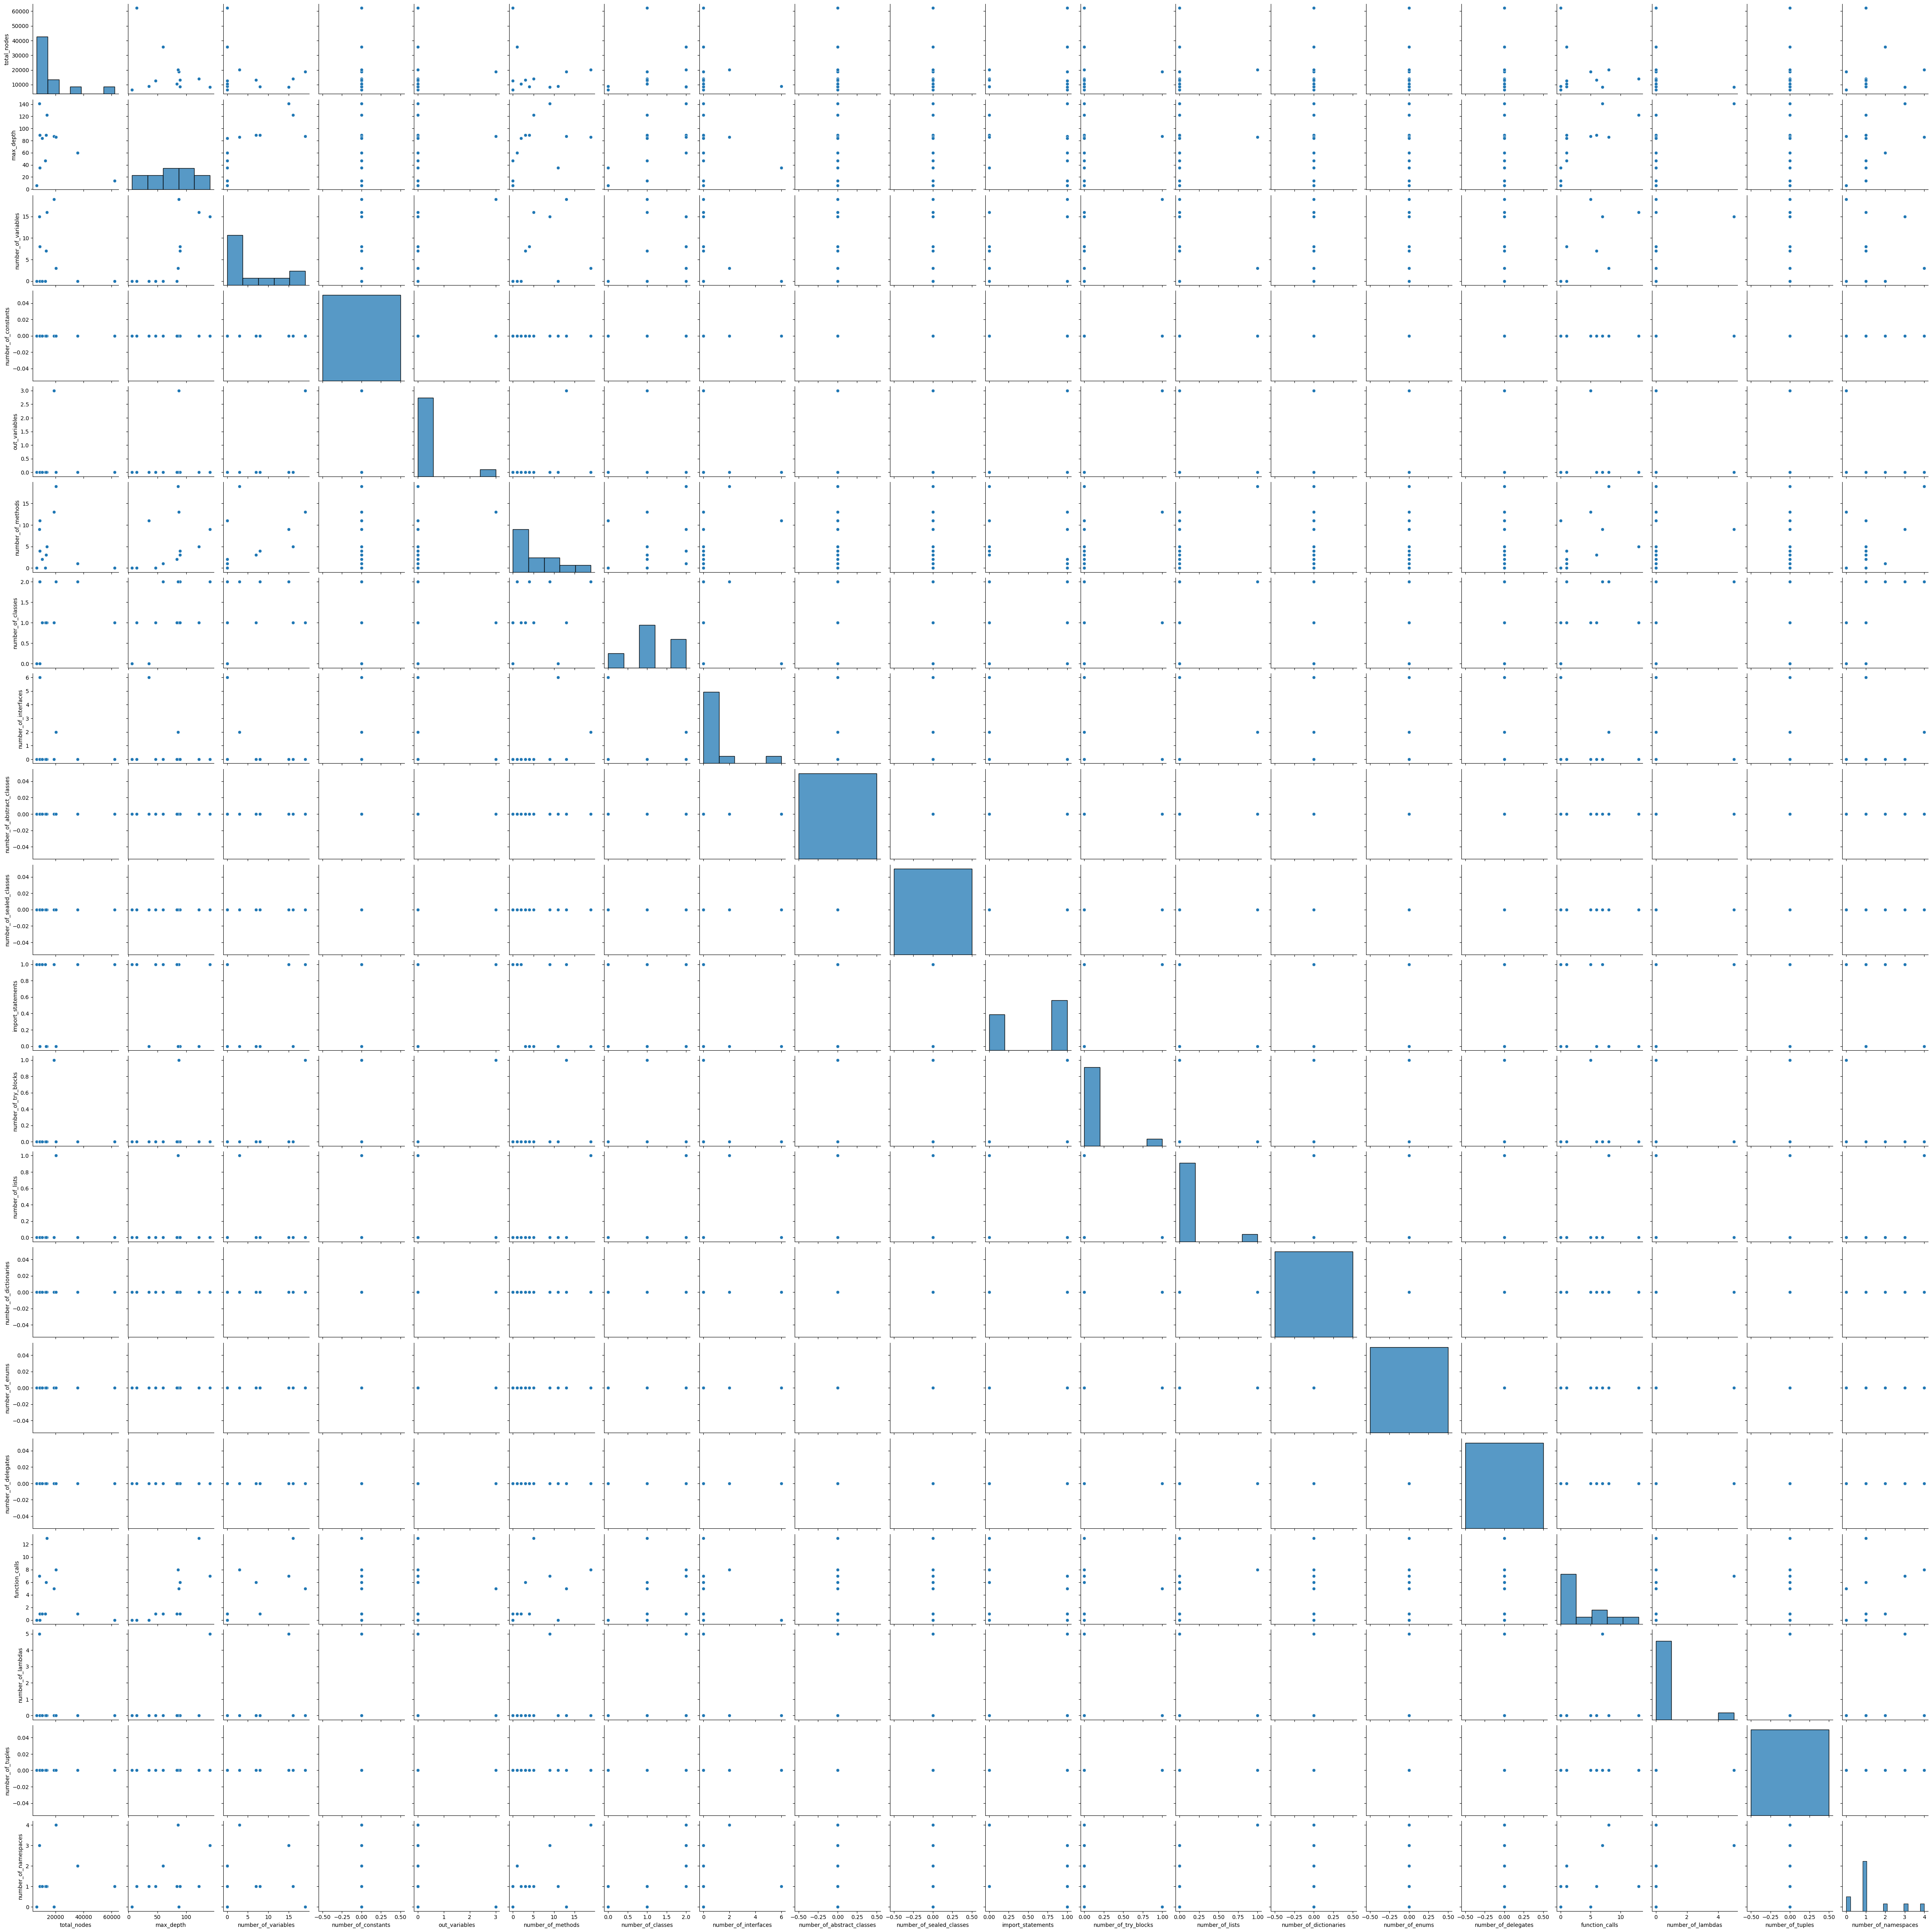

In [20]:
p = sns.pairplot(data)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   total_nodes                     12 non-null     int64 
 1   node_count                      12 non-null     object
 2   max_depth                       12 non-null     int64 
 3   number_of_variables             12 non-null     int64 
 4   number_of_constants             12 non-null     int64 
 5   out_variables                   12 non-null     int64 
 6   number_of_methods               12 non-null     int64 
 7   number_of_classes               12 non-null     int64 
 8   number_of_interfaces            12 non-null     int64 
 9   number_of_abstract_classes      12 non-null     int64 
 10  number_of_sealed_classes        12 non-null     int64 
 11  import_statements               12 non-null     int64 
 12  number_of_try_blocks            12 non-null     int6

## Decsion Tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split()